In [24]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy

%matplotlib inline
# %matplotlib

In [25]:
# https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(float(x), float(y), float(z), float(dx), float(dy), float(dz), mutation_scale=5, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [15]:
from matplotlib.axes import Axes
def _fancy_arrow(ax, x, y, dx, dy, *args, **kwargs):
    arrow = FancyArrowPatch((x, y), (x + dx, y + dy), mutation_scale=5, *args, **kwargs)
    ax.add_patch(arrow)
    
setattr(Axes, 'fancy_arrow', _fancy_arrow)

In [16]:
def grad(f, *vs):
    return [f.diff(x) for x in vs]
def hessian(f, *vs):
    return [[f.diff(x).diff(y) for y in vs] for x in vs]

In [61]:
class Function:
    
    def plot3(self, left, right, n, steps = []):
        X, Y, Z = self._calc_func(left, right, n)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_wireframe(X, Y, Z)
    
        for ((x, y), (dx, dy)) in self._get_arrows(steps):
            z = self.__call__(x, y)
            dz = self.__call__(x + dx, y + dy) - z
            ax.arrow3D(x, y, z, dx, dy, dz, color='red')
            
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')
        return fig
    
    def plot_contours(self, left, right, n, levels, steps = []):
        X, Y, Z = self._calc_func(left, right, n)
        fig = plt.figure()
        ax = plt.subplot()
        cntrs = ax.contour(X, Y, Z, levels = levels)
        fmt = {}
        for c in cntrs.levels:
            fmt[c] = '%.02f' % c
        ax.clabel(cntrs, cntrs.levels[::1], fmt=fmt)

        for ((x, y), (dx, dy)) in self._get_arrows(steps):
            ax.fancy_arrow(x, y, dx, dy, color='red')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        return fig
    
    def _calc_func(self, left, right, n):
        assert self.arity() == 2, "Only functions with 2 arguments supported"
        X = np.linspace(left, right, n)
        Y = np.linspace(left, right, n)
        X, Y = np.meshgrid(X, Y)
        Z = []
        for i in range(len(X)):
            z = []
            for j in range(len(Y)):
                z.append(self.__call__(X[i][j], Y[i][j]))
            Z.append(np.array(z, dtype='float64'))
        Z = np.array(Z, dtype='float64')
        return (X, Y, Z)
    
    def _get_arrows(self, steps = []):
        if len(steps) == 0:
            return
        prev = steps[0]
        for p in steps[1:]:
            yield ((prev[0], prev[1]), (p[0] - prev[0], p[1] - prev[1]))
            prev = p
            
        
class QuadFunction(Function):
    
    def __init__(self, A, b, c):
            self.A = np.array(list(map(np.array, A)))
            self.b = np.array(b)
            self.c = c
            
    def __call__(self, *x):
        x = np.array(x)
        return 1/2 * self.A.dot(x).dot(x) + self.b.dot(x) + self.c
    
    def grad(self, *x):
        return self.A.dot(x) + self.b
    def hessian(self, *x):
        return self.A

    def arity(self):
        return len(self.b)
    
class RegularFunction(Function):
    
    def __init__(self, expr, *args):
        self.expr = expr
        self.vars = args
    
    def _eval(self, expr, *x):
        res = expr
        for (a, v) in zip(self.vars, x):
            res = res.subs(a, v)
        return res
    
    def __call__(self, *x):
        return self._eval(self.expr, *x)
    
    def grad(self, *x):
        return np.array(list(map(lambda e: self._eval(e, *x), grad(self.expr, *self.vars))))
    
    def hessian(self, *x):
        H = hessian(self.expr, *self.vars)
        return np.array(list(map(lambda l: np.array(list(map(lambda e: self._eval(e, *x), l))), H)))
        # return H
        
    def arity(self):
        return len(self.vars)

In [18]:
import enum
import subprocess
import os
from pathlib import Path

class Method(enum.Enum):
    MARQUARDT = 'marquardt'
    MARQUARDT_CHOLESKY = 'marquardt_cholesky'
    POWELL = 'powell'
    BFS = 'bfs'
    NEWTON_ORDINARY =  'newton_ordinary'
    NEWTON_WITH_SEARCH = 'newton_with_search'
    NEWTON_WITH_DESCENT = 'newton_with_descent'


class Runner:
    
    build_dir = Path('../../build')
    
    def __init__(self):
        pass
    
    def run(self, method, init, eps = 1e-4):
        cli = self.build_dir / 'lab4cli/lab4cli'
        proc = subprocess.Popen([str(cli), 
                                 '-m', method.value, 
                                 '-i', ' '.join(map(str, init)), 
                                 '-e', str(eps)], stdout=subprocess.PIPE)
        out = proc.communicate()[0].decode()
#         print(out)
        return self._parse_output(out.split(), init)
        
    def _parse_output(self, out, init):
        def nxt():
            return out.pop(0)
        def nxt_int():
            return int(nxt())
        def nxt_float():
            return float(nxt())
        def test(ch):
            if len(out) == 0:
                return False
            if out[0] == ch:
                nxt()
                return True
            else:
                return False
        def read_extra():
            extra = []
            if test('['):
                while not test(']'):
                    extra.append(nxt_int())
            return extra
        def nxt_flist(n):
            res = []
            for i in range(n):
                res.append(nxt_float())
            return res
        n = len(init)
        f_min = nxt_float()
        x_min = nxt_flist(n)
        
        iters = nxt_int()
        iters_data = [(init, [])]
        for i in range(iters):
            iters_data.append((nxt_flist(n), read_extra()))
        return (x_min, iters_data)
    
def get_steps(data):
    res = []
    x_min = data[0][0][0]
    x_max = data[0][0][0]
    y_min = data[0][0][1]
    y_max = data[0][0][1]
    for (d, _) in data:
        x_min = min(x_min, d[0])
        x_max = max(x_max, d[0])
        x_min = min(x_min, d[1])
        x_max = max(x_max, d[1])
        res.append(d)
    x_range = x_max - x_min
    x_min = x_min - x_range/3
    x_max = x_max + x_range/3
    y_range = y_max - y_min
    y_min = y_min - y_range/3
    y_max = y_max + y_range/3
    return (res, min(x_min, y_min), max(x_max, y_max))

def get_extra(data, i = None):
    res = []
    for (_, e) in data:
        if i == None:
            res.append(e)
        else:
            res.append(e[i])
    return res

def get_levels(f, steps):
    return list(set(map(lambda a: f(*a), steps))).sort()

In [55]:
def plot_all_methods_abstr(f, init, plt_impl):
    runner = Runner()
    for method in Method:
        (x_min, data) = runner.run(method, init)
        (steps, left, right) = get_steps(data)
        fig = plt_impl(f, left, right, 10, steps)
        fig.suptitle(method.value)
        
def plot_all_contours(f, init):
    def impl(f, left, right, dens, steps):
        return f.plot_contours(left, right, dens, get_levels(f, steps), steps)
    return plot_all_methods_abstr(f, init, impl)

def plot_all_3D(f, init):
    def impl(f, left, right, dens, steps):
        return f.plot3(left, right, dens, steps)
    return plot_all_methods_abstr(f, init, impl)

# Function 1
$f(x) = \frac{1}{2} \left\langle \begin{pmatrix} 2 & -1 \\ -1 & 1 \end{pmatrix} x, x \right\rangle + \langle \begin{pmatrix} 2 & -3 \end{pmatrix} , x \rangle + 10$

$x_0 = \begin{pmatrix} 1 & 1 \end{pmatrix}$

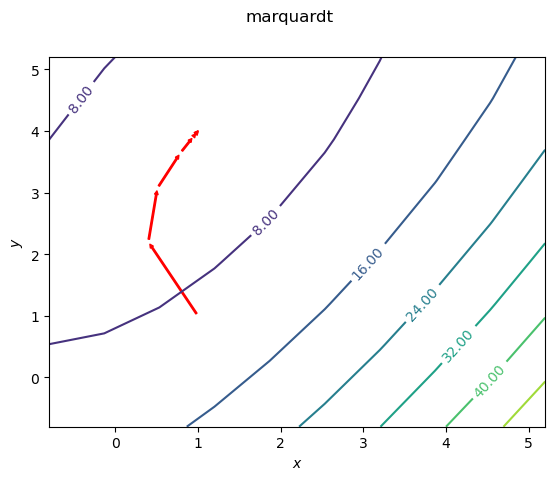

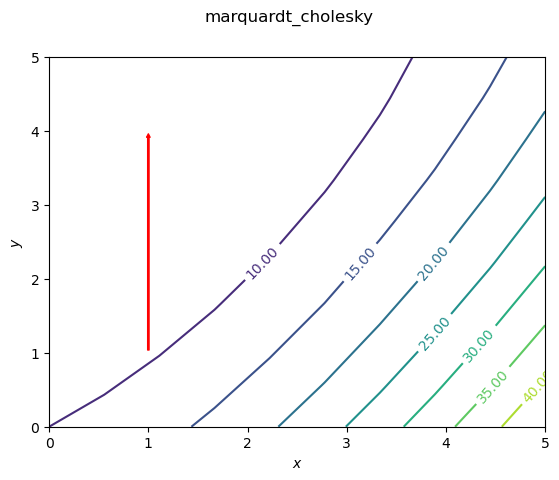

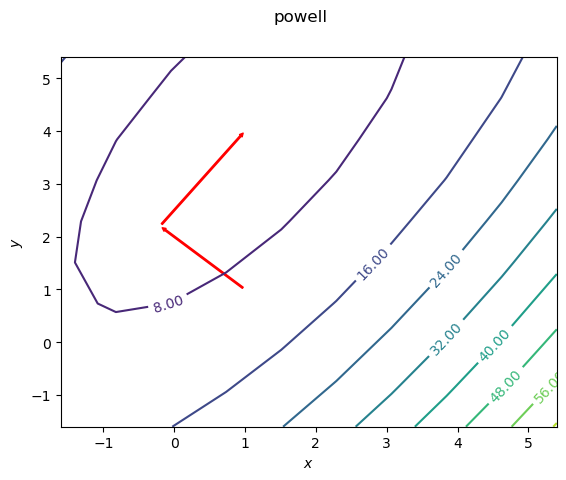

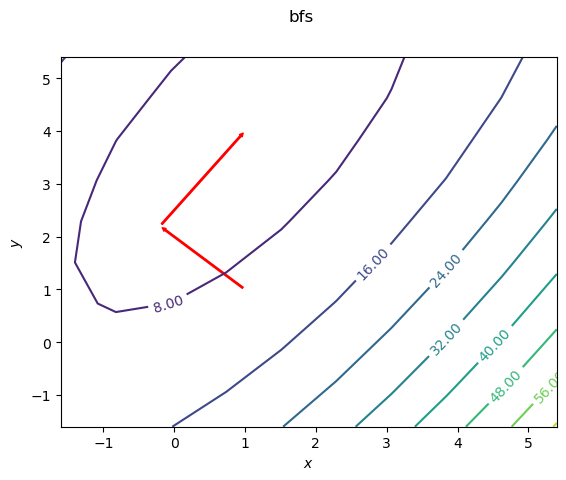

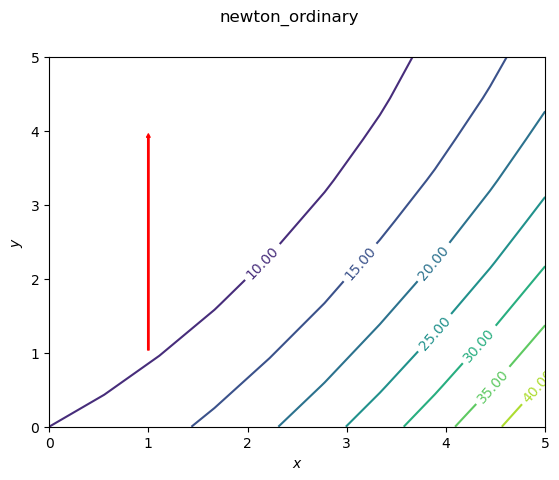

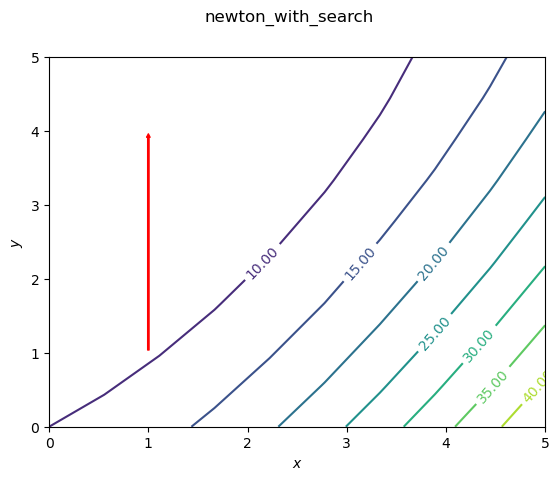

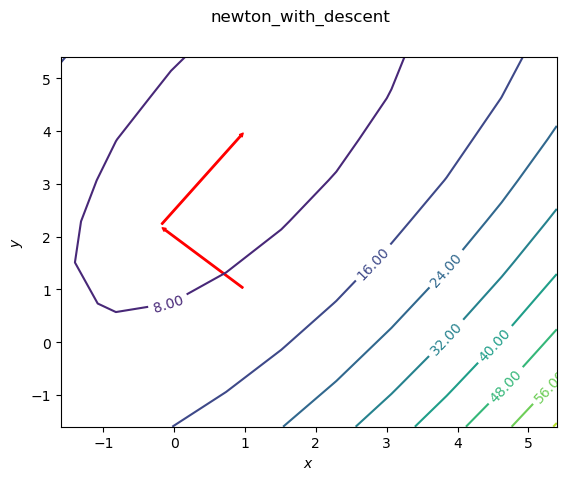

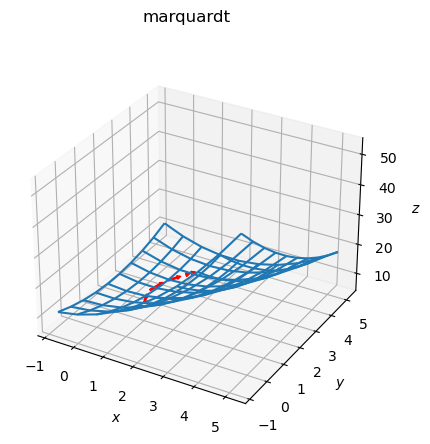

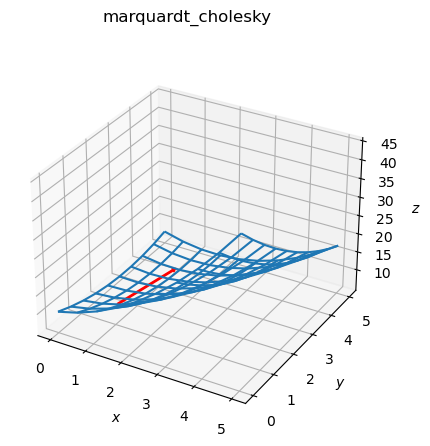

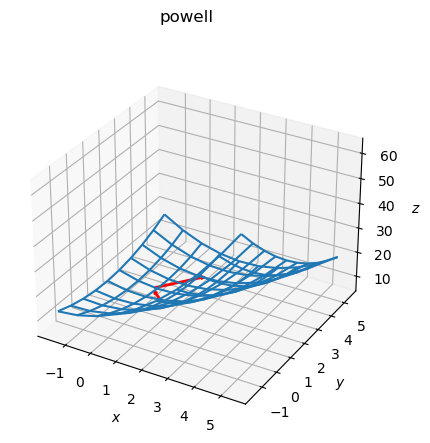

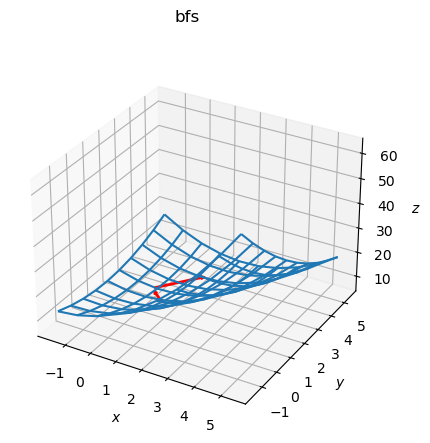

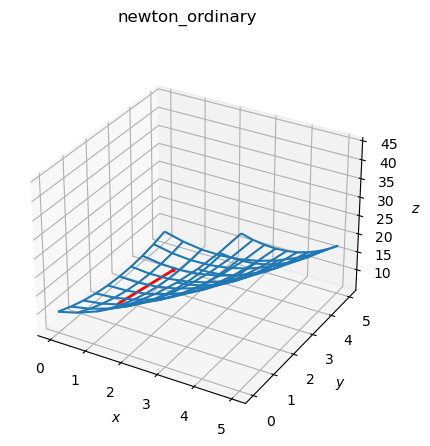

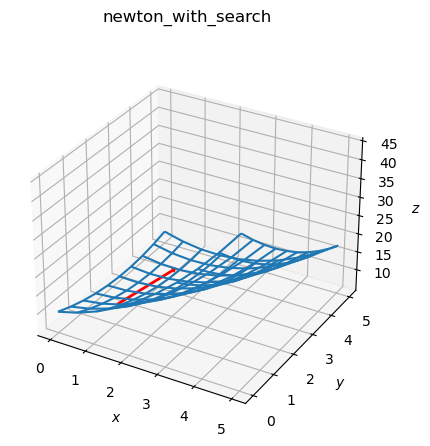

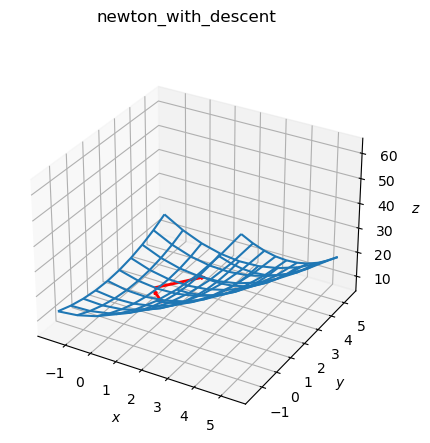

In [62]:
f = QuadFunction([[2, -1], [-1, 1]], [2, -3], 10)
plot_all_contours(f, [1, 1])
plot_all_3D(f, [1, 1])

x**2*y + 2*x**2 + 3*y**2
[2*x*y + 4*x x**2 + 6*y]
[[2*y + 4 2*x]
 [2*x 6]]


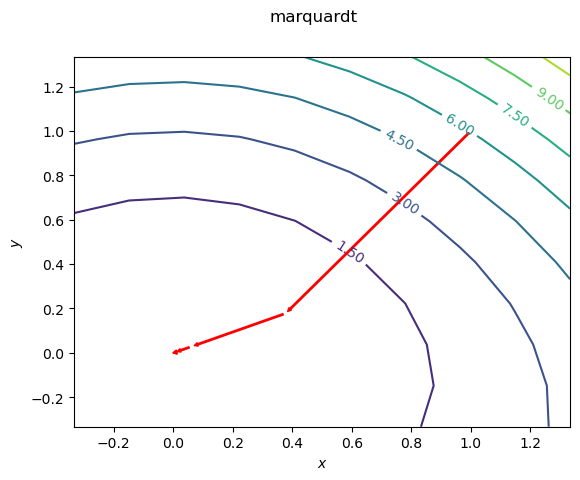

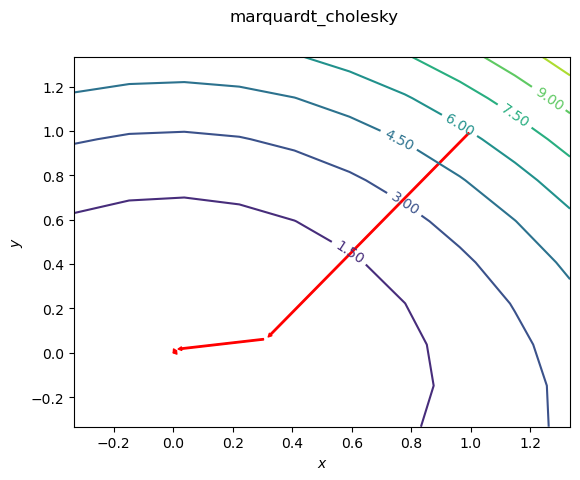

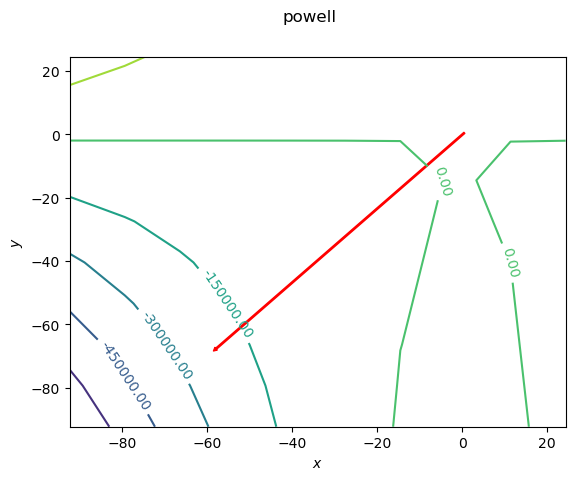

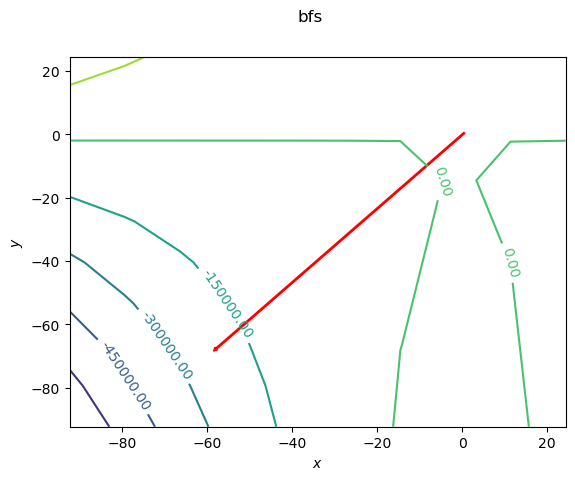

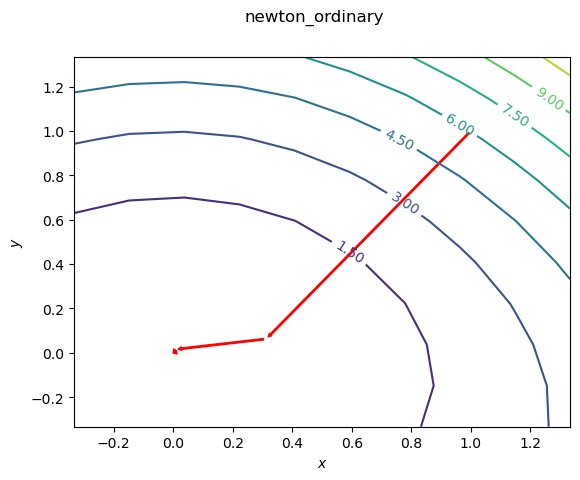

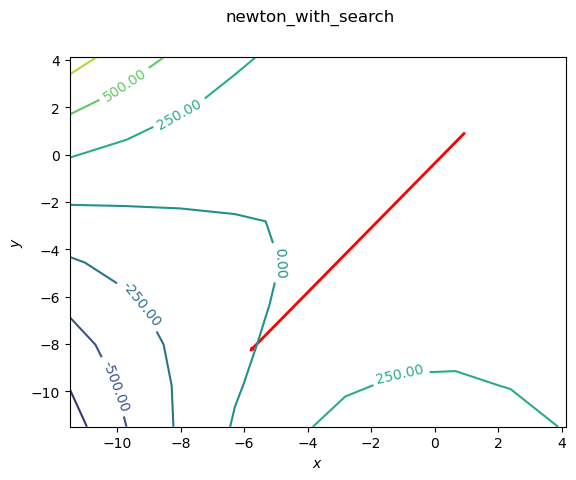

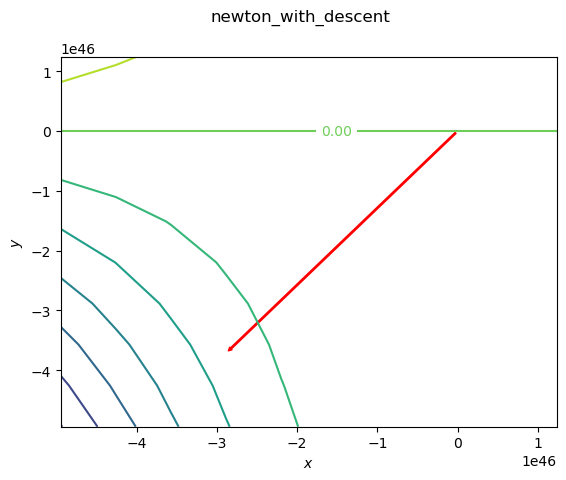

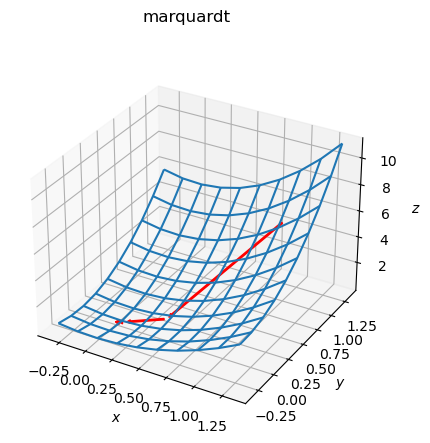

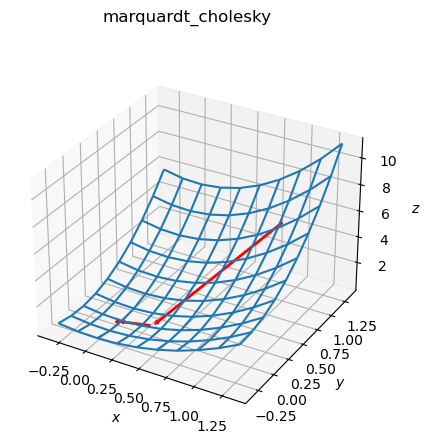

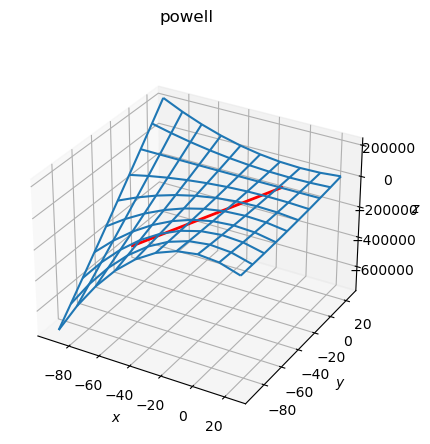

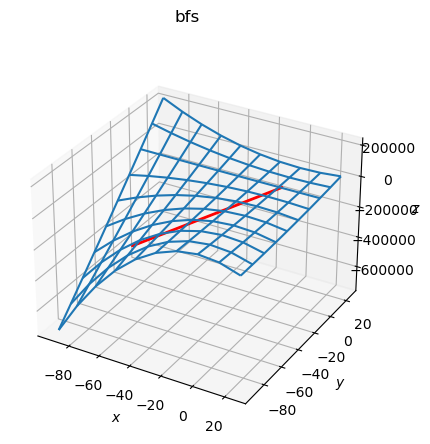

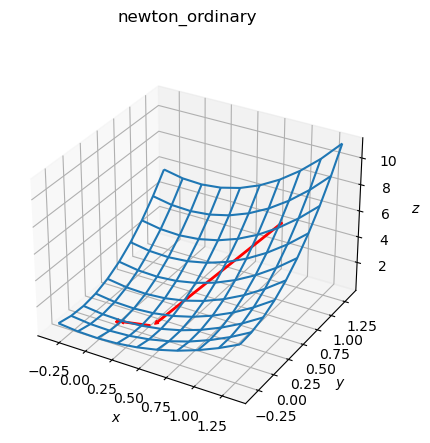

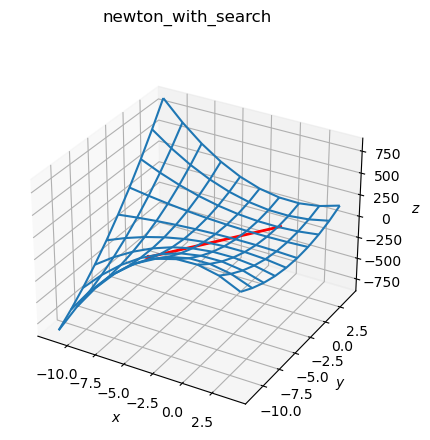

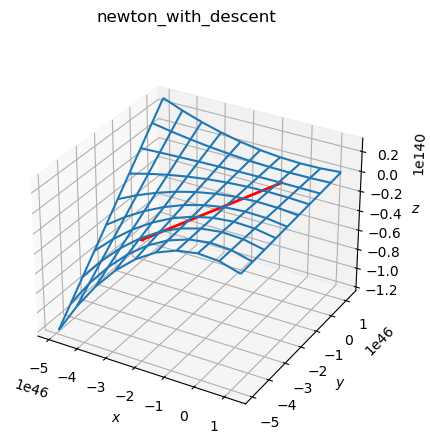

In [83]:
x, y = sy.Symbol('x'), sy.Symbol('y')
f = RegularFunction(2 * x * x + 3 * y * y + x**2 * y, x, y)
print(f(x, y))
print(f.grad(x, y))
print(f.hessian(x, y))
plot_all_contours(f, [1, 1])
plot_all_3D(f, [1, 1])